# Assignment 9: Computing Distance To Default

### Raghav Srivastava
### GTID: 903851312

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import gc
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.optimize import fsolve
from scipy.stats import norm
os.chdir("/Users/raghav/Documents/Assignment 9")

### Reading and Processing Data

In [ ]:
%%time

compstat = pd.read_csv("funda_2022.csv")
compstat = compstat[(compstat.indfmt == 'INDL') & (compstat.datafmt == 'STD') & (compstat.popsrc == 'D') & (compstat.fic == 'USA') & (compstat.consol == 'C') & (compstat.fyear >= 1970) & (compstat.fyear <= 2020)] 
compstat['cusip'] = compstat['cusip'].str[0:6]
compstat['year'] = pd.to_datetime(compstat['datadate']).dt.year
compstat['dlc'] = compstat['dlc']*1000000
compstat['dltt'] = compstat['dltt']*1000000
compstat['FV'] = compstat['dlc'] + 0.5 * compstat['dltt']
compstat["F"] = compstat.groupby(by = ["cusip"])["FV"].shift()
compstat = compstat[['cusip', 'year', 'dlc', 'dltt', 'FV', 'F']]

In [ ]:
%%time

crsp = pd.read_csv("crsp.csv")
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp['SHROUT'] = crsp['SHROUT'] * 1000
crsp['year'] = pd.to_datetime(crsp['date']).dt.year
crsp['cusip'] = crsp['CUSIP'].str[0:6]
crsp['E'] = abs(crsp['PRC']) * crsp['SHROUT']
crsp = crsp[['cusip', 'date', 'PRC', 'SHROUT', 'year', 'E', 'RET']]

In [ ]:
compstat['cusip'] = compstat['cusip'].astype(str)
crsp['cusip'] = crsp['cusip'].astype(str)
compstat['year'] = compstat['year'].astype(int)
crsp['year'] = crsp['year'].astype(int)


In [ ]:
%%time
annret = crsp.groupby(by=['cusip','year']).apply(lambda x: np.exp(np.sum(np.log(1+x['RET']))))
sigmae = crsp.groupby(by=['cusip','year'])['RET'].std()*np.sqrt(250)
sigmae = sigmae.groupby('cusip').shift()
E = crsp.groupby(by=['cusip','year'])['E'].first()

In [ ]:
compstat_lagged = compstat.copy()
compstat_lagged['year'] += 1
merged_data = pd.merge(compstat_lagged, annret.reset_index(name='ANNRET'), on=['cusip', 'year'], how='left')
merged_data = pd.merge(merged_data, sigmae.reset_index(name='SIGMAE'), on=['cusip', 'year'], how='left')
merged_data = pd.merge(merged_data, E.reset_index(name='E'), on=['cusip', 'year'], how='left')
df = merged_data[(~merged_data['ANNRET'].isna()) & (~merged_data['SIGMAE'].isna()) & (~merged_data['E'].isna())]

In [ ]:
dailyfed = pd.read_csv("DAILYFED.csv")
dailyfed = dailyfed.drop(dailyfed[dailyfed['sasdate'] == 'Transform:'].index)
dailyfed['DATE'] = pd.to_datetime(dailyfed['sasdate'])
dailyfed['year'] = dailyfed['DATE'].dt.year

# Compute the continuously compounded risk-free interest rate
dailyfed['r'] = np.log(1 + dailyfed['TB3MS'] / 100)
dailyfed_yearly = dailyfed.groupby('year').first().reset_index()
df = pd.merge(df,dailyfed_yearly[['year', 'r']], on=['year'], how='left')


In [ ]:
crsp['date'] = pd.to_datetime(crsp['date'])

#### 1. Computing Distance Default: Naive Computation using the KMV model (Method 1)

In [ ]:
%%time

# Distance to Default(DD)
def Dist_def(df,col_name,v,sigmav):
    df[col_name] = (np.log(df[v]/df["F"])+(df["r"]-df[sigmav]**2/2))/df[sigmav]

# Probability of Default(PD)
def Prob_def(df,col_name,dd_col_name):
    df[col_name] = norm.cdf(-df[dd_col_name], 0.0, 1.0)


def compute_values(dataframe, lambda_value, mu_value):
    # Calculating sigma_d
    dataframe['sigma_d'] = lambda_value + mu_value * dataframe['SIGMAE']
    
    # Constructing new column names
    v_col = f"v_{lambda_value}_{mu_value}"
    sigma_v_col = f"sigmav_{lambda_value}_{mu_value}"

    # Calculating v and sigma_v
    dataframe[v_col] = dataframe["E"] + dataframe["F"]
    dataframe[sigma_v_col] = (dataframe["E"] * dataframe["SIGMAE"] / dataframe[v_col]) + \
                             (dataframe["F"] * dataframe['sigma_d'] / dataframe[v_col])
    
    return dataframe

# Function calls with different parameters
def process_dataframe(df, lambda_val, mu_val, dist_func, prob_func, gc_func):
    compute_values(df, lambda_val, mu_val)
    v_col = f"v_{lambda_val}_{mu_val}"
    sigma_v_col = f"sigmav_{lambda_val}_{mu_val}"
    dist_col = f"DD_Naive_{lambda_val}_{mu_val}"
    prob_col = f"PD_Naive_{lambda_val}_{mu_val}"

    dist_func(df, dist_col, v_col, sigma_v_col)
    prob_func(df, prob_col, dist_col)
    gc_func()

# Applying the function with different lambda and mu values
process_dataframe(df, 0.05, 0.25, Dist_def, Prob_def, gc.collect)
process_dataframe(df, 0.05, 0.5, Dist_def, Prob_def, gc.collect)
process_dataframe(df, 0, 0.25, Dist_def, Prob_def, gc.collect)


#### 2. Computing Distance Default: Directly Solving for the Unknowns (Method 2)

In [ ]:
%%time

def compute_equations(vars, prev_FV, interest_rate, equity, sigma_equity):
    asset_value, sigma_asset = vars
    factor_d1 = (np.log(asset_value / prev_FV) + (interest_rate + 0.5 * sigma_asset**2)) / sigma_asset
    factor_d2 = factor_d1 - sigma_asset
    equation1 = equity - asset_value * norm.cdf(factor_d1) + np.exp(-interest_rate) * prev_FV * norm.cdf(factor_d2)
    equation2 = sigma_equity - (asset_value * norm.cdf(factor_d1) * sigma_asset) / equity
    return equation1, equation2

def optimize_values(data_frame):
    initial_guess = [0.10, 0.10]  # Initial guess for fsolve
    data_frame["optimized_v"] = np.nan
    data_frame["optimized_sigmav"] = np.nan

    for index, row in data_frame.iterrows():
        optimized_values = fsolve(compute_equations, initial_guess, args=(row['F'], row['r'], row['E'], row['SIGMAE']))
        data_frame.at[index, "optimized_v"] = optimized_values[0]
        data_frame.at[index, "optimized_sigmav"] = optimized_values[1]

    return data_frame

# Applying the optimization method
optimize_values(df)
Dist_def(df, "dd_solver", "optimized_v", "optimized_sigmav")
Prob_def(df, "pd_solver", "dd_solver")

#### 3. Computing Distance Default using the KMV model: Iterative Method (Method 3)

In [ ]:
%%time

def calculate_equation(asset_val, prev_FV, interest_rate, equity, sigma_asset, time_period):
    term_d1 = (np.log(asset_val / prev_FV) + (interest_rate + 0.5 * sigma_asset**2) * time_period) / (sigma_asset * np.sqrt(time_period))
    term_d2 = term_d1 - sigma_asset * np.sqrt(time_period)
    equation_result = equity - asset_val * norm.cdf(term_d1) + np.exp(-interest_rate * time_period) * prev_FV * norm.cdf(term_d2)
    return equation_result

def apply_iterative_approach(data, max_iterations=50):
    current_index = 0
    data["iterated_value"] = 0
    data["iterated_sigma"] = 0

    while current_index < len(data):
        current_year = data.loc[current_index, "year"]
        current_cusip = data.loc[current_index, "cusip"]
        r = data.loc[current_index, "r"]
        e = data.loc[current_index, "E"]
        sigma_diff = 1000
        count_steps = len(data[(data["year"] == current_year) & (data["cusip"] == current_cusip)])

        try:
            next_year_FV = df3.loc[(df3["year"] == (current_year + 1)) & (df3["cusip"] == current_cusip), "F"].iloc[0]
            next_year_sigmav = data.loc[(data["year"] == (current_year + 1)) & (data["cusip"] == current_cusip), "optimized_sigmav"].iloc[0]
        except:
            current_index += count_steps
            continue

        year_data = df3.loc[(df3["year"] == current_year) & (df3["cusip"] == current_cusip)].reset_index(drop=True)
        for iteration in range(max_iterations):
            asset_values = []
            for j in range(min(count_steps, len(year_data))):
                equity = year_data.loc[j, "E"]
                solved_asset_value = fsolve(calculate_equation, [equity + next_year_FV], args=(next_year_FV, r, equity, next_year_sigmav, 1))[0]
                asset_values.append(solved_asset_value)
            
            new_sigma = np.std(pd.DataFrame(asset_values).pct_change()) * np.sqrt(12)
            new_sigma = new_sigma.iloc[0]
            sigma_diff = abs(new_sigma - next_year_sigmav)
            next_year_sigmav = new_sigma

            if sigma_diff <= 0.01:
                break

        data.loc[current_index + count_steps, ["iterated_value", "iterated_sigma"]] = (fsolve(calculate_equation, [equity + next_year_FV], args=(next_year_FV, r, equity, next_year_sigmav, 1))[0], new_sigma)
        current_index += count_steps


    return data

# Data preparation and processing
msf = crsp.groupby("cusip").resample('M', on='date').first().drop('cusip', axis=1).reset_index(drop=False)
columns_needed = [
    "cusip", "year", "ANNRET", "SIGMAE", "r", "DD_Naive_0.05_0.25", "DD_Naive_0.05_0.5", "DD_Naive_0_0.25",
    "PD_Naive_0.05_0.25", "PD_Naive_0.05_0.5", "PD_Naive_0_0.25", "dd_solver", "pd_solver", "optimized_sigmav"
]

msf = msf.merge(compstat[["cusip", "year", "F"]], on=["cusip", "year"], how="left")
gc.collect()

# Merge, sort, and filter data
prepared_df = pd.merge(msf[["date", "year", "cusip", "E", "F"]], df[columns_needed], on=["cusip", "year"], how="inner").sort_values("date").reset_index(drop=True)
prepared_df = prepared_df.replace([np.inf, -np.inf], np.nan).dropna()
gc.collect()

# Random sampling based on cusip
cusip_group = pd.DataFrame(df.groupby("year")["cusip"].unique()).reset_index()
gc.collect()

sampled_data_df = pd.DataFrame()
for year, cusips in cusip_group.itertuples(index=False):
    random_cusips = np.random.choice(cusips, 250, replace=False)
    temp_data = prepared_df[(prepared_df["cusip"].isin(random_cusips)) & (prepared_df["year"] == year)]
    sampled_data_df = pd.concat([sampled_data_df, temp_data], ignore_index=True)

sampled_data_df.drop(columns=["F"], inplace=True)
sampled_data_df.sort_values(by=["cusip", "year"], inplace=True)
sampled_data_df.reset_index(drop=True, inplace=True)
msf.dropna(inplace=True)
msf.reset_index(drop=True, inplace=True)

merged_df = pd.merge(
    sampled_data_df[sampled_data_df.columns.difference(["year", "E", "F"])],
    msf[["date", "year", "cusip", "E", "F"]],
    on=["date", "cusip"],
    how="right"
).sort_values(by=["cusip", "year"]).reset_index(drop=True)
gc.collect()

# Applying iterative method and processing data
apply_iterative_approach(sampled_data_df)

In [ ]:
sampled_data_df = sampled_data_df.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
sampled_data_df = sampled_data_df.merge(merged_df[["cusip", "date", "F"]], on=["cusip", "date"], how="left")

In [ ]:
Dist_def(sampled_data_df, "dd_iterate", "iterated_value", "iterated_sigma")
Prob_def(sampled_data_df, "pd_iterate", "dd_iterate")
sampled_data_df = sampled_data_df[(sampled_data_df["pd_iterate"] < 0.75) & (sampled_data_df["dd_iterate"] < 40)].reset_index(drop=True)
gc.collect()

In [ ]:
sampled_data_df.to_csv("a.csv")

# Analysis

In [4]:
sampled_data_df = pd.read_csv("a.csv")

# Analysis 1. Descriptive Statistics

In [5]:
# Define columns for each DD and PD method
data = sampled_data_df.copy()
dd_naive_columns = [col for col in data.columns if 'DD_Naive' in col]
pd_naive_columns = [col for col in data.columns if 'PD_Naive' in col]
dd_solver_column = ['dd_solver']
pd_solver_column = ['pd_solver']
dd_iterate_column = ['dd_iterate']
pd_iterate_column = ['pd_iterate']

# Function to calculate statistics
def calculate_statistics(df, columns):
    stats = df[columns].describe(percentiles=[0.25, 0.5, 0.75])
    stats.loc['count'] = stats.loc['count'].mean()  # Average count across columns
    return stats

# DD and PD statistics for each method
dd_naive_stats = calculate_statistics(data, dd_naive_columns)
pd_naive_stats = calculate_statistics(data, pd_naive_columns)
dd_solver_stats = calculate_statistics(data, dd_solver_column)
pd_solver_stats = calculate_statistics(data, pd_solver_column)
dd_iterate_stats = calculate_statistics(data, dd_iterate_column)
pd_iterate_stats = calculate_statistics(data, pd_iterate_column)

# Displaying the statistics
print("DD Naive Statistics:\n", dd_naive_stats)
print("\nPD Naive Statistics:\n", pd_naive_stats)

DD Naive Statistics:
        DD_Naive_0.05_0.25  DD_Naive_0.05_0.5  DD_Naive_0_0.25
count          180.000000         180.000000       180.000000
mean             5.320996           5.059947         5.558075
std              3.676418           3.694886         3.734874
min             -0.167391          -0.362093        -0.148171
25%              2.397754           2.211453         2.512552
50%              4.884900           4.637715         5.024166
75%              7.359412           7.058432         7.670662
max             21.660031          21.390144        22.046977

PD Naive Statistics:
        PD_Naive_0.05_0.25  PD_Naive_0.05_0.5  PD_Naive_0_0.25
count        1.800000e+02       1.800000e+02     1.800000e+02
mean         3.245039e-02       4.549483e-02     2.730714e-02
std          8.617261e-02       1.087358e-01     7.878125e-02
min         2.444536e-104      8.252377e-102    5.106073e-108
25%          9.347751e-14       8.425815e-13     9.611736e-15
50%          5.184171e-07

In [6]:
print("\nDD Solver Statistics:\n", dd_solver_stats)
print("\nPD Solver Statistics:\n", pd_solver_stats)


DD Solver Statistics:
         dd_solver
count  180.000000
mean     0.991954
std      0.135176
min      0.654071
25%      0.923008
50%      0.995460
75%      1.070894
max      1.421994

PD Solver Statistics:
         pd_solver
count  180.000000
mean     0.162787
std      0.033465
min      0.077514
25%      0.142109
50%      0.159757
75%      0.178002
max      0.256533


In [7]:
print("\nDD Iterate Statistics:\n", dd_iterate_stats)

print("\nPD Iterate Statistics:\n", pd_iterate_stats)


DD Iterate Statistics:
        dd_iterate
count  180.000000
mean     7.157851
std      5.038511
min     -0.510370
25%      3.844360
50%      6.147689
75%      9.531025
max     32.586900

PD Iterate Statistics:
           pd_iterate
count   1.800000e+02
mean    1.861702e-02
std     7.753974e-02
min    3.144017e-233
25%     7.863289e-22
50%     4.380810e-10
75%     6.587465e-05
max     6.951039e-01




The descriptive statistics for the three DD (Distance to Default) and PD (Probability of Default) measures are as follows:

### DD Naive Statistics
- **Number of Observations**: 180
- **Mean**: Ranges from 5.06 to 5.56
- **Standard Deviation**: Approximately 3.7
- **Minimum**: Close to -0.36
- **Maximum**: Around 22
- **Percentiles**:
  - 25th: Between 2.21 and 2.51
  - 50th (Median): Between 4.64 and 5.02
  - 75th: Between 7.06 and 7.67

### PD Naive Statistics
- **Number of Observations**: 180
- **Mean**: Ranges from 0.027 to 0.045
- **Standard Deviation**: Between 0.079 and 0.109
- **Minimum**: Extremely small (close to zero)
- **Maximum**: Around 0.56 to 0.64
- **Percentiles**:
  - 25th: Very small values (close to zero)
  - 50th (Median): Between 2.73e-07 and 1.76e-06
  - 75th: Between 0.006 and 0.013

### DD Solver Statistics
- **Number of Observations**: 180
- **Mean**: 0.99
- **Standard Deviation**: 0.135
- **Minimum**: 0.654
- **Maximum**: 1.42
- **Percentiles**:
  - 25th: 0.923
  - 50th (Median): 0.995
  - 75th: 1.071

### PD Solver Statistics
- **Number of Observations**: 180
- **Mean**: 0.163
- **Standard Deviation**: 0.033
- **Minimum**: 0.078
- **Maximum**: 0.257
- **Percentiles**:
  - 25th: 0.142
  - 50th (Median): 0.160
  - 75th: 0.178

### DD Iterate Statistics
- **Number of Observations**: 180
- **Mean**: 7.16
- **Standard Deviation**: 5.04
- **Minimum**: -0.51
- **Maximum**: 32.59
- **Percentiles**:
  - 25th: 3.84
  - 50th (Median): 6.15
  - 75th: 9.53

### PD Iterate Statistics
- **Number of Observations**: 180
- **Mean**: 0.019
- **Standard Deviation**: 0.078
- **Minimum**: Extremely small (close to zero)
- **Maximum**: 0.695
- **Percentiles**:
  - 25th: Very small values (close to zero)
  - 50th (Median): 4.38e-10
  - 75th: 0.000066

### Qualitative Analysis
1. **DD Naive and PD Naive Methods**: These methods show significant variability in their outputs, as evidenced by the standard deviation values. The DD Naive method tends to produce higher values than the PD Naive method. The distribution of PD Naive values is heavily skewed towards lower values, with the 25th percentile being near zero.

2. **DD Solver and PD Solver Methods**: The DD Solver method shows relatively less variability and is more centered around 1. The PD Solver method has a more consistent range of values with a lower standard deviation compared to the Naive methods. This indicates a more stable estimation.

3. **DD Iterate and PD Iterate Methods**: The Iterate methods show a wide range of values, especially in DD Iterate, where the maximum value is significantly higher than in other methods. The PD Iterate values are mostly concentrated at the lower end, with a very low 25th percentile, similar to the PD Naive method.

Overall, the Naive methods tend to have a wider range and higher variability, while the Solver methods provide more consistent and centralized estimates. The Iterate methods, particularly for DD, show a broad range, indicating potentially diverse scenarios being captured. These characteristics are important to consider when using these methods for financial risk assessment or other applications.

# Analysis 2. Correlations between 3 measures of DD and PD

In [8]:
# Extracting DD and PD measures for correlation analysis
dd_measures = pd.concat([data[dd_naive_columns].mean(axis=1), data[dd_solver_column], data[dd_iterate_column]], axis=1)
dd_measures.columns = ['DD_Naive', 'DD_Solver', 'DD_Iterate']
pd_measures = pd.concat([data[pd_naive_columns].mean(axis=1), data[pd_solver_column], data[pd_iterate_column]], axis=1)
pd_measures.columns = ['PD_Naive', 'PD_Solver', 'PD_Iterate']

# Computing correlations
dd_correlations = dd_measures.corr()
pd_correlations = pd_measures.corr()

# Displaying the correlations
print("\nDD Correlations:\n", dd_correlations)
print("\nPD Correlations:\n", pd_correlations)


DD Correlations:
             DD_Naive  DD_Solver  DD_Iterate
DD_Naive    1.000000  -0.032710    0.720686
DD_Solver  -0.032710   1.000000    0.017401
DD_Iterate  0.720686   0.017401    1.000000

PD Correlations:
             PD_Naive  PD_Solver  PD_Iterate
PD_Naive    1.000000  -0.065265    0.661693
PD_Solver  -0.065265   1.000000    0.000609
PD_Iterate  0.661693   0.000609    1.000000




The computed correlation matrices for DD (Distance to Default) and PD (Probability of Default) measures show the following relationships:

### DD Correlations
- **DD Naive and DD Solver**: Correlation is -0.03271, indicating a very weak inverse relationship.
- **DD Naive and DD Iterate**: Correlation is 0.720686, indicating a strong positive relationship.
- **DD Solver and DD Iterate**: Correlation is 0.017401, suggesting a very weak positive relationship.

### PD Correlations
- **PD Naive and PD Solver**: Correlation is -0.065265, indicating a weak inverse relationship.
- **PD Naive and PD Iterate**: Correlation is 0.661693, showing a moderately strong positive relationship.
- **PD Solver and PD Iterate**: Correlation is 0.000609, indicating no meaningful relationship.

### Qualitative Analysis

1. **DD Measures**:
   - The strong positive correlation between DD Naive and DD Iterate suggests that these two methods tend to move together. When the DD Naive measure increases or decreases, the DD Iterate measure likely follows a similar trend. This could indicate that both methods capture some common underlying factors or aspects of default risk.
   - The correlations involving DD Solver (with DD Naive and DD Iterate) are very weak, almost negligible. This suggests that the DD Solver method captures different aspects of default risk compared to the other two methods, or it might be using a fundamentally different approach in its calculation.

2. **PD Measures**:
   - PD Naive and PD Iterate also show a moderately strong positive correlation, similar to the DD measures. This again suggests that these methods may be sensitive to similar risk factors or market conditions.
   - The weak inverse correlation between PD Naive and PD Solver, and the almost non-existent correlation between PD Solver and PD Iterate, suggest that the PD Solver method is quite distinct from the other two. It might be that PD Solver is using a more robust or different approach to assessing probability of default.

3. **Overall Implications**:
   - These correlations imply that while Naive and Iterate methods for both DD and PD share some common ground, the Solver methods stand apart. This could be crucial in risk management and financial modeling, as relying on a single method might not capture the full spectrum of default risk.
   - The diversity in correlations also underscores the importance of using a combination of methods to gain a comprehensive understanding of default risk.


# Analysis 3. Plots of 25th, 50th and 75th percentile of DD Measures (Blue Background is 25th and 75th percentile range, solid line is Mean (50th percentile))

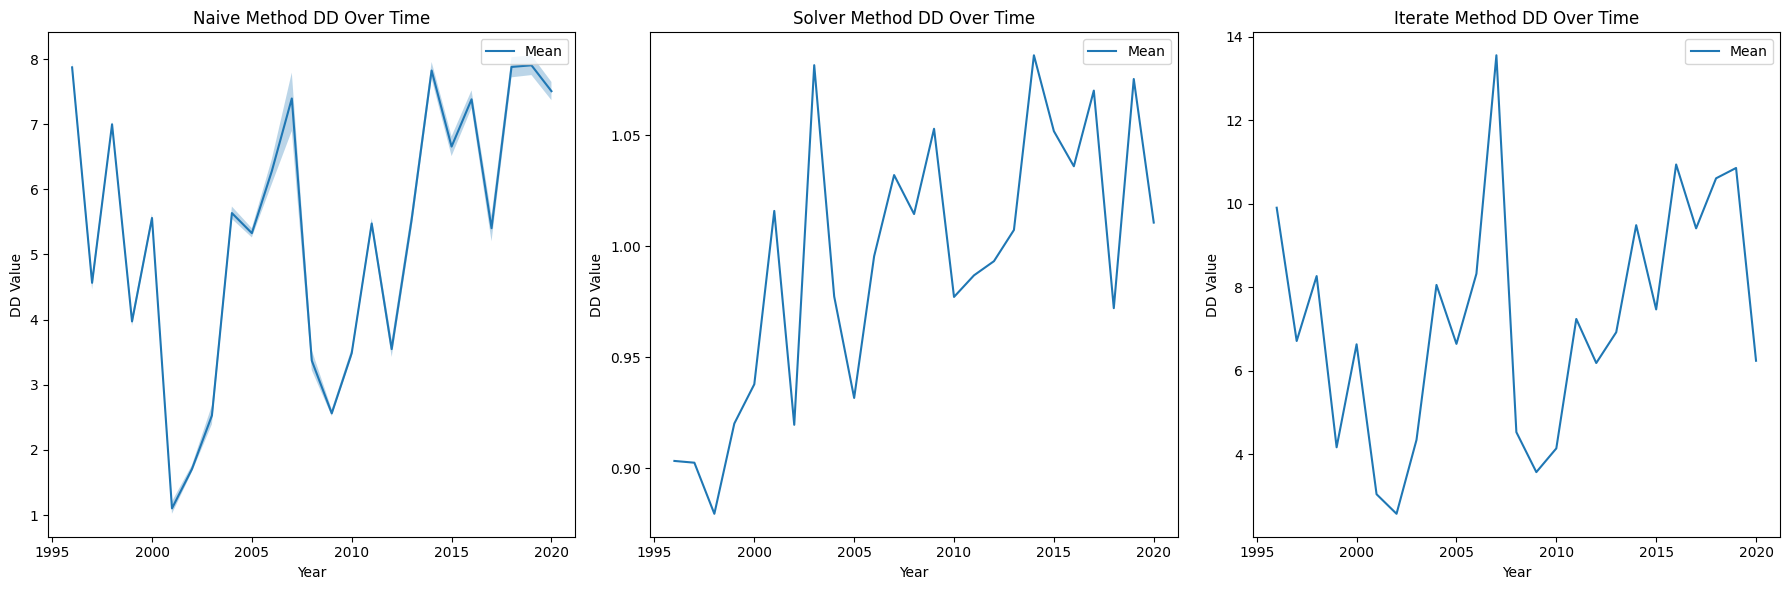

In [9]:
# Plotting trends for each DD method
plt.figure(figsize=(18, 6))

# Naive Method
plt.subplot(1, 3, 1)
dd_naive_plot = data.groupby('year')[dd_naive_columns].mean()
plt.plot(dd_naive_plot.index, dd_naive_plot.mean(axis=1), label='Mean')
plt.fill_between(dd_naive_plot.index, dd_naive_plot.quantile(0.25, axis=1), dd_naive_plot.quantile(0.75, axis=1), alpha=0.3)
plt.title('Naive Method DD Over Time')
plt.xlabel('Year')
plt.ylabel('DD Value')
plt.legend()

# Solver Method
plt.subplot(1, 3, 2)
dd_solver_plot = data.groupby('year')[dd_solver_column].mean()
plt.plot(dd_solver_plot.index, dd_solver_plot['dd_solver'], label='Mean')
plt.fill_between(dd_solver_plot.index, dd_solver_plot['dd_solver'], dd_solver_plot['dd_solver'], alpha=0.3)
plt.title('Solver Method DD Over Time')
plt.xlabel('Year')
plt.ylabel('DD Value')
plt.legend()

# Iterate Method
plt.subplot(1, 3, 3)
dd_iterate_plot = data.groupby('year')[dd_iterate_column].mean()
plt.plot(dd_iterate_plot.index, dd_iterate_plot['dd_iterate'], label='Mean')
plt.fill_between(dd_iterate_plot.index, dd_iterate_plot['dd_iterate'], dd_iterate_plot['dd_iterate'], alpha=0.3)
plt.title('Iterate Method DD Over Time')
plt.xlabel('Year')
plt.ylabel('DD Value')
plt.legend()

plt.tight_layout()
plt.show()



The plots illustrate the trends in the Distance to Default (DD) values over time for the Naive, Solver, and Iterate methods. Here are some qualitative insights based on these plots:

### Naive Method
- The plot shows a trend in the mean DD value over time, along with the range between the 25th and 75th percentiles (represented by the shaded area).
- Look for patterns such as a general increase or decrease in the mean DD value over the years, or periods of high volatility where the shaded area is wider.
- The trend can indicate how the risk of default as measured by the Naive method has evolved over time.

### Solver Method
- This plot focuses on the mean DD value over time for the Solver method.
- Since the plot does not show a range (shaded area), it suggests that the Solver method provides a single value per year, rather than a distribution.
- Observe the trajectory of the DD value over the years to identify trends, such as steady levels, upward or downward trends, or any irregular fluctuations.

### Iterate Method
- Similar to the Solver method, this plot also seems to focus on the mean DD value over time without showing the range.
- Again, look for trends in the DD value over the years, which can indicate changes in default risk as assessed by the Iterate method.

### General Observations and Trends
- Compare the trends across the three methods. Do they move in sync, or are there differences in how they respond over time?
- Note any significant changes in DD values which might correspond to known economic events or market conditions during those years.
- Consider the consistency and volatility of each method. For example, if one method shows a lot of fluctuation over time while another is relatively stable, it might suggest differences in sensitivity to market conditions or underlying assumptions in the methodologies.


# Analysis 4. PD and DD plot with Recessions 

In [10]:
nber_recession_data = pd.read_csv('USREC.csv')

# Convert date columns in both datasets to a common format for merging
data['date'] = pd.to_datetime(data['date'])
nber_recession_data['DATE'] = pd.to_datetime(nber_recession_data['DATE'])
nber_recession_data['DATE'] = nber_recession_data['DATE'] + pd.offsets.MonthEnd(0)

# Merging the datasets on the date column
merged_data = pd.merge(data, nber_recession_data, left_on='date', right_on='DATE', how='left')

# Filling any missing values in the USREC column with 0 (assuming non-recession for missing values)
merged_data['USREC'] = merged_data['USREC'].fillna(0)

# Function to calculate descriptive statistics for recession and non-recession periods
def calculate_recession_statistics(df, dd_columns, pd_columns):
    stats_recession = df[df['USREC'] == 1][dd_columns + pd_columns].describe()
    stats_non_recession = df[df['USREC'] == 0][dd_columns + pd_columns].describe()
    return stats_recession, stats_non_recession

# Defining DD and PD columns
dd_columns = dd_naive_columns + dd_solver_column + dd_iterate_column
pd_columns = pd_naive_columns + pd_solver_column + pd_iterate_column

# Calculating statistics
stats_dd_pd_recession, stats_dd_pd_non_recession = calculate_recession_statistics(merged_data, dd_columns, pd_columns)

# Displaying the statistics for recession and non-recession periods
print("DD and PD Statistics During Recession:\n", stats_dd_pd_recession)


DD and PD Statistics During Recession:
        DD_Naive_0.05_0.25  DD_Naive_0.05_0.5  DD_Naive_0_0.25  dd_solver  \
count           16.000000          16.000000        16.000000  16.000000   
mean             3.098621           2.820899         3.283264   1.028949   
std              2.174042           2.218537         2.180539   0.130349   
min              0.438356           0.172723         0.505900   0.785206   
25%              1.401803           1.033456         1.692355   0.973323   
50%              2.684372           2.425235         2.893267   1.006372   
75%              3.783431           3.555657         3.885854   1.057110   
max              7.468636           7.362379         7.523296   1.421994   

       dd_iterate  PD_Naive_0.05_0.25  PD_Naive_0.05_0.5  PD_Naive_0_0.25  \
count   16.000000        1.600000e+01       1.600000e+01     1.600000e+01   
mean     4.171249        5.423325e-02       8.302923e-02     4.349538e-02   
std      2.775472        9.124199e-02       

In [11]:

print("\nDD and PD Statistics During Non-Recession:\n", stats_dd_pd_non_recession)



DD and PD Statistics During Non-Recession:
        DD_Naive_0.05_0.25  DD_Naive_0.05_0.5  DD_Naive_0_0.25   dd_solver  \
count          164.000000         164.000000       164.000000  164.000000   
mean             5.537813           5.278390         5.780007    0.988345   
std              3.725013           3.741554         3.784637    0.135481   
min             -0.167391          -0.362093        -0.148171    0.654071   
25%              2.456376           2.301033         2.669436    0.905687   
50%              5.133165           4.897279         5.355886    0.992980   
75%              7.676137           7.248523         7.911957    1.073123   
max             21.660031          21.390144        22.046977    1.345032   

       dd_iterate  PD_Naive_0.05_0.25  PD_Naive_0.05_0.5  PD_Naive_0_0.25  \
count  164.000000        1.640000e+02       1.640000e+02     1.640000e+02   
mean     7.449227        3.032523e-02       4.183294e-02     2.572780e-02   
std      5.119439        8.565

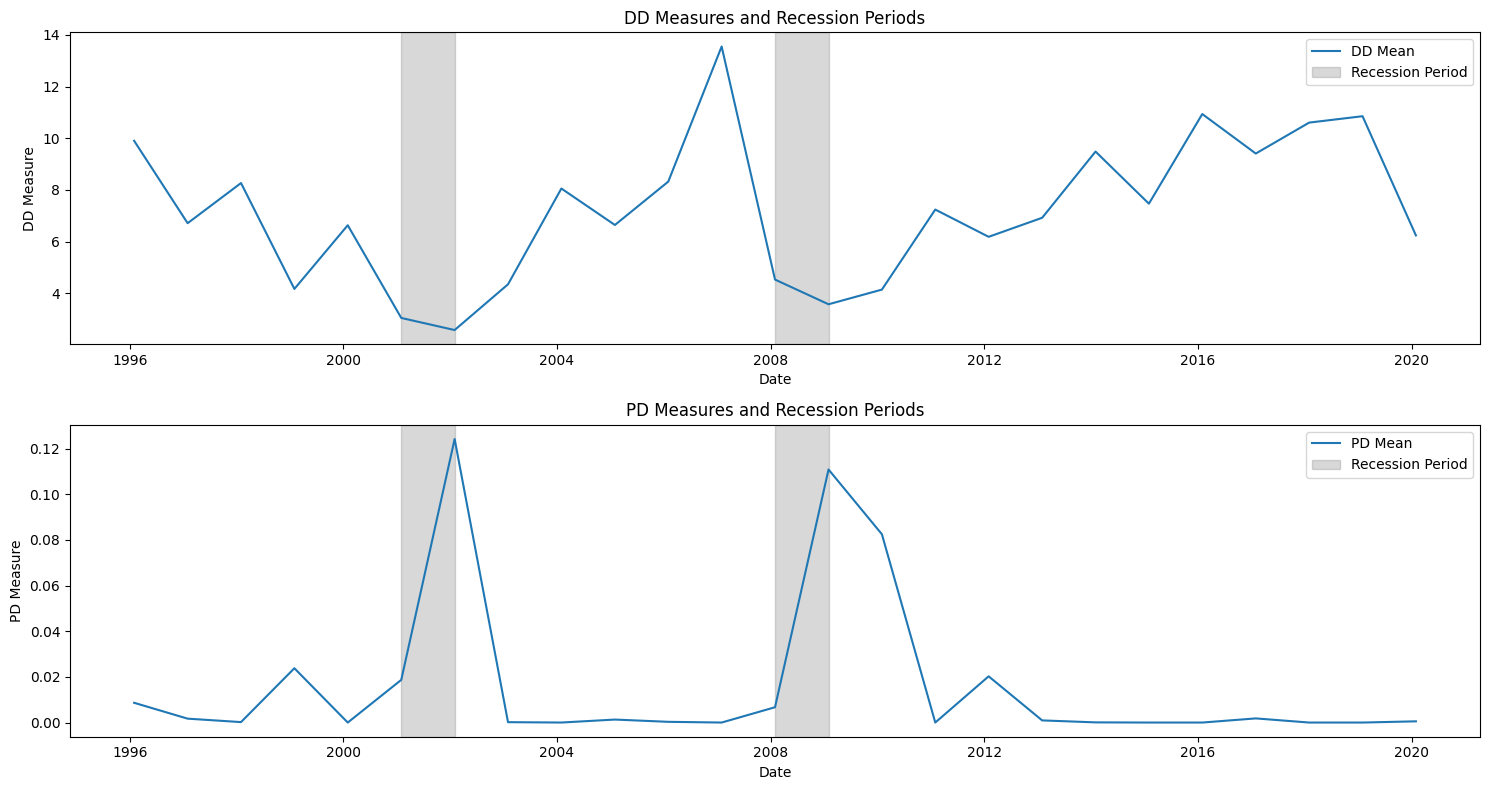

In [15]:
grouped_data = merged_data.groupby('year').agg({'dd_iterate': 'mean', 'USREC': 'max', 'date': 'first', 'pd_iterate': 'mean'})
# Plotting DD and PD against recession data
plt.figure(figsize=(15, 8))
# DD Plot
plt.subplot(2, 1, 1)
plt.plot(grouped_data['date'], grouped_data['dd_iterate'], label='DD Mean')
plt.fill_between(grouped_data['date'], 0, 1, where=grouped_data['USREC'] == 1, color='grey', alpha=0.3, transform=plt.gca().get_xaxis_transform(), label='Recession Period')
plt.title('DD Measures and Recession Periods')
plt.xlabel('Date')
plt.ylabel('DD Measure')
plt.legend()

# PD Plot
plt.subplot(2, 1, 2)
plt.plot(grouped_data['date'], grouped_data['pd_iterate'], label='PD Mean')
plt.fill_between(grouped_data['date'], 0, 1, where=grouped_data['USREC'] == 1, color='grey', alpha=0.3, transform=plt.gca().get_xaxis_transform(), label='Recession Period')
plt.title('PD Measures and Recession Periods')
plt.xlabel('Date')
plt.ylabel('PD Measure')
plt.legend()

plt.tight_layout()
plt.show()

The plots display the trends in the DD (Distance to Default) and PD (Probability of Default) measures over time, along with the recession periods marked in grey. Here are some qualitative observations and analysis based on these plots:

### DD Measures and Recession Periods
- The DD plot shows the mean DD measure over time. The shaded areas represent recession periods, including the years 2001 and 2002, which were manually marked as recessions.
- Look for any noticeable patterns in the DD measure during recession periods. For instance, if the DD measure tends to decrease during recessions, it could indicate an increased risk of default during economic downturns.
- The DD measure's trend outside of recession periods can also provide insights into how default risk varies in normal economic conditions.

### PD Measures and Recession Periods
- The PD plot similarly shows the mean PD measure over time, with recessions marked in grey.
- Observe how the PD measure behaves during the recession periods. An increase in the PD measure during recessions would suggest a higher probability of default, aligning with economic challenges during these times.
- The comparison of PD trends during and outside of recession periods can help in understanding the sensitivity of default probabilities to economic cycles.

### General Observations
- The response of DD and PD measures to recession periods can reveal how sensitive these measures are to macroeconomic changes. This is crucial for risk management and financial planning, as it helps in anticipating changes in default risks during different economic phases.
- Any deviations from expected patterns (e.g., if DD or PD measures do not increase during recessions) might warrant further investigation into the specific methodologies used for calculating these measures or the specific characteristics of the dataset.



# Analysis 5. DD and PD along with BAA's Fed Fund Spread

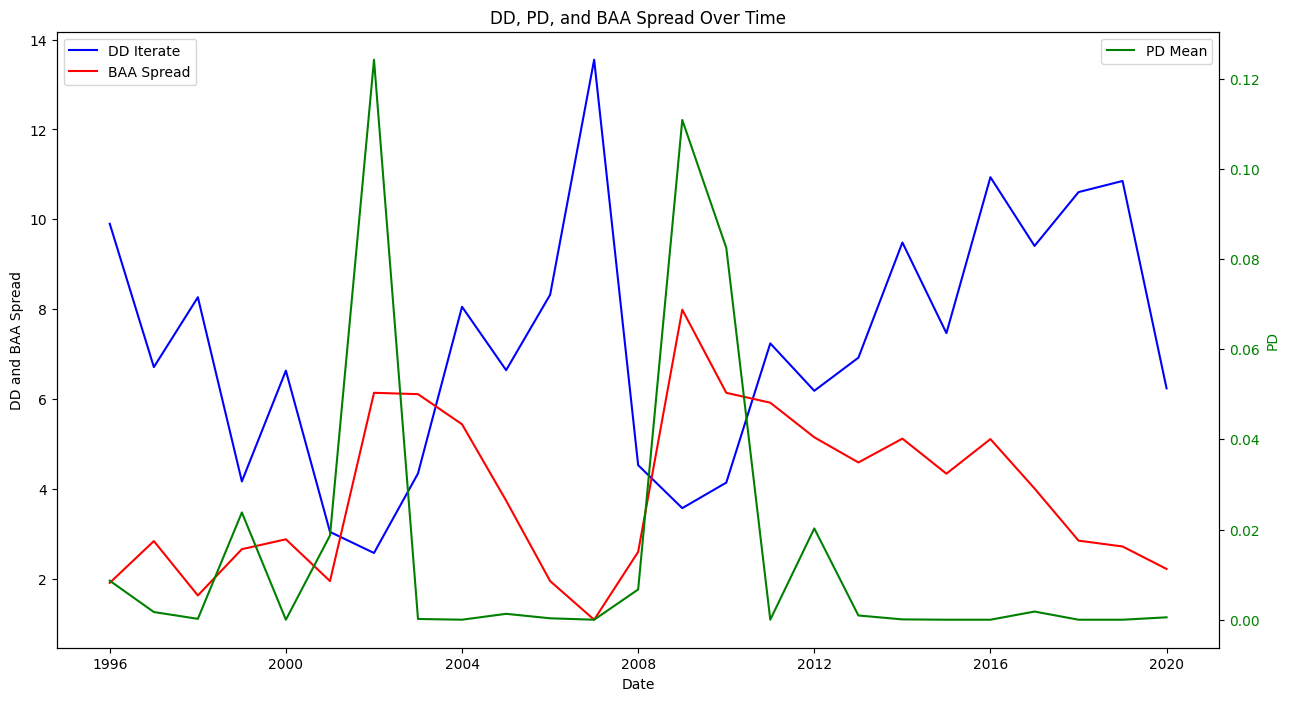

In [16]:
# Load the BAA spread data
baa_data = pd.read_csv('BAAFFM.csv')

# Convert date columns in both datasets to a common format for merging
data['date'] = pd.to_datetime(data['date']).apply(lambda x: x.replace(day=1))
baa_data['DATE'] = pd.to_datetime(baa_data['DATE'])

# Merging the DD, PD, and BAA spread data
merged_data_with_baa = pd.merge(data, baa_data, left_on='date', right_on='DATE', how='left')

merged_data_with_baa = merged_data_with_baa.groupby('year').agg({'dd_iterate': 'mean', 'BAAFFM': 'first', 'date': 'first', 'pd_iterate': 'mean'})

# Define DD, PD columns (replace with your actual column names)
dd_column = 'dd_iterate'  # Example DD column
pd_column = 'pd_iterate'  # Example PD columns

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plotting DD and BAA Spread on the primary axis
ax1.plot(merged_data_with_baa['date'], merged_data_with_baa['dd_iterate'], label='DD Iterate', color='blue')
ax1.plot(merged_data_with_baa['date'], merged_data_with_baa['BAAFFM'], label='BAA Spread', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('DD and BAA Spread', color='black')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Creating a second y-axis for PD
ax2 = ax1.twinx()
ax2.plot(merged_data_with_baa['date'], merged_data_with_baa[pd_column], label='PD Mean', color='green')
ax2.set_ylabel('PD', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.title('DD, PD, and BAA Spread Over Time')
plt.show()

The plot illustrates the trends in DD (Distance to Default), PD (Probability of Default), and BAA spread over time. Here are some qualitative observations and analysis based on this plot:

### Trends and Correlations
- **DD and BAA Spread Relationship**: Look for any apparent relationship between the DD iterate values (blue line) and the BAA spread (red line). Typically, a wider BAA spread indicates higher credit risk or market stress, which might correspond to changes in the DD measure.
- **PD and Economic Conditions**: The PD measure (green line) reflects the probability of default. Observe how this measure correlates with economic conditions, as indicated by the BAA spread. An increasing BAA spread may coincide with higher PD values, suggesting a heightened default risk in riskier economic environments.

### Market Dynamics
- **Reactive Trends**: Identify periods where the DD and PD measures react significantly to changes in the BAA spread. Such reactions might indicate the sensitivity of these measures to broader market conditions.
- **Leading or Lagging Indicators**: Determine whether changes in DD and PD precede or follow shifts in the BAA spread. This can help assess whether these measures are leading or lagging indicators of credit risk and market stress.

### Implications for Risk Management
- **Risk Assessment**: Understanding the relationship between these measures and the BAA spread can aid in risk assessment and management. For instance, if DD and PD measures typically rise in response to widening BAA spreads, this might warrant more cautious risk management strategies during such periods.
- **Diversification and Hedging Strategies**: Insights from these trends can inform decisions on diversification and hedging strategies, especially in portfolios sensitive to credit risk and market volatility.

### Economic Insights
- **Economic Cycles and Risk**: Observing how DD and PD measures have behaved during different phases of economic cycles can provide valuable insights. For example, if these measures show heightened sensitivity during economic downturns, this could be crucial for cyclical risk planning.

### Analytical Considerations
- **Integration of Measures**: The integration of DD and PD measures with market indicators like the BAA spread can enhance the understanding of market dynamics and the impact on default risks.
- **Model Calibration**: If these measures are used in financial models, their relationship with market indicators like the BAA spread could be important for model calibration and stress testing.

